## Loading and Preparing Data

In [ ]:
# import modules
import json
import ast
from pandas import DataFrame, Series

In [ ]:
# load metadata
fr=open("meta_Appliances.json")
fw=open("Amazon_Appliances_Metadata.json", "w")

for line in fr:
    json_dat = json.dumps(ast.literal_eval(line))
    dict_dat = json.loads(json_dat)
    json.dump(dict_dat, fw)
    fw.write("\n")

fw.close()
fr.close()

In [ ]:
# load reviews data
fr=open("reviews_Appliances.json")
fw=open("Amazon_Appliances_Reviews.json", "w")

for line in fr:
    json_dat = json.dumps(ast.literal_eval(line))
    dict_dat = json.loads(json_dat)
    json.dump(dict_dat, fw)
    fw.write("\n")

fw.close()
fr.close()

In [ ]:
# inspecting metadata
list_of_appliances_metadata_dict_data = [json.loads(line) for line in open('Amazon_Appliances_Metadata.json')]
appliances_metadata_df = DataFrame(list_of_appliances_metadata_dict_data)
appliances_metadata_df.head()
#appliances_metadata_df.info()

,asin,price,imUrl,description,categories,title,brand,related,salesRank
0,0970408285,40.75,http://ecx.images-amazon.com/images/I/41kQjPIF...,High-pressure hose 90 end & hose washer instal...,"[[Appliances, Parts & Accessories, Washer Part...",NaN,NaN,NaN,NaN
1,7301113188,NaN,http://ecx.images-amazon.com/images/I/41EfFOPw...,NaN,"[[Appliances, Freezers, Chest Freezers]]",NaN,NaN,NaN,NaN
2,B00002N7HY,2.29,http://ecx.images-amazon.com/images/I/316Y1KbT...,"Built of durable thermoplastic, Leviton Power ...","[[Appliances, Parts & Accessories, Range Parts...","Leviton 5050 50 Amp, 125/250 Volt, NEMA 10-50R...",Leviton,"{'also_bought': ['B000BPFZHM', 'B000VU1KC6', '...",NaN
3,B00002NATH,9.13,http://ecx.images-amazon.com/images/I/41srC2QF...,"Built of durable thermoplastic, Leviton Power ...","[[Appliances, Parts & Accessories, Range Parts...","Leviton 7313 30 Amp, 125 Volt, NEMA Tt-30R, 2P...",Leviton,"{'also_bought': ['B002OUMU66', 'B007HFT034', '...",NaN
4,B00004SQH9,16.29,http://ecx.images-amazon.com/images/I/41eg0Hvy...,Coleman Cable 3536 14/3 General-Use Appliance ...,"[[Appliances, Parts & Accessories, Refrigerato...",Coleman Cable 3536 14/3 General-Use Appliance ...,Coleman Cable,"{'also_bought': ['B000XSNDS0', 'B0022NH420', '...",NaN


In [ ]:
# inspecting reviews data
list_of_appliances_reviews_dict_data = [json.loads(line) for line in open('Amazon_Appliances_Reviews.json')]
appliances_reviews_df = DataFrame(list_of_appliances_reviews_dict_data)
appliances_reviews_df.head()
#appliances_reviews_df.info()
#appliances_reviews_df.shape

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A27HOWZBUBJ8FF,0970408285,Steve,"[0, 0]",Could have been longer though. well made and e...,4.0,Good fit,1387152000,"12 16, 2013"
1,A24HQ894NFSTF5,7301113188,"Maha Saqfalhait ""shopaholic! ;)""","[0, 0]",I like these containers so much i have ordered...,5.0,I Love the Freezer storage line..,1236902400,"03 13, 2009"
2,AXE83MK90ZEVZ,B00002N7HY,Strom,"[0, 0]","It works, no fires, etc. Why not 5 stars? Ho...",4.0,expectations achieved.,1389052800,"01 7, 2014"
3,A2J7X7ZIH2EWB1,B00002NATH,NaN,"[0, 0]",Fast shipping. Works great,5.0,Five Stars,1405814400,"07 20, 2014"
4,AJQFNOFTZ7GOX,B00002NATH,Barthbill,"[1, 1]",What can I say? It is the usual Leviton high q...,5.0,good product at a good price.,1277164800,"06 22, 2010"


In [ ]:
# save metadata to csv
appliances_metadata_df.to_csv('Amazon_Appliances_Metadata.csv', encoding='utf-8', index=False)

# save reviews data to csv
appliances_reviews_df.to_csv('Amazon_Appliances_Reviews.csv', encoding='utf-8', index=False)

## Data Wrangling

In [ ]:
# filtering relavent columns to use for nlp-based recommender system
import pandas as pd
df = pd.read_csv('Amazon_Appliances_Reviews.csv')
df = df[['asin', 'reviewText']]
df.head()

,asin,reviewText
0,0970408285,Could have been longer though. well made and e...
1,7301113188,I like these containers so much i have ordered...
2,B00002N7HY,"It works, no fires, etc. Why not 5 stars? Ho..."
3,B00002NATH,Fast shipping. Works great
4,B00002NATH,What can I say? It is the usual Leviton high q...


In [ ]:
# additional wrangling
# drop any rows with missing values
df.dropna(inplace=True)

# drop any duplicate rows
df.drop_duplicates(inplace=True)

In [ ]:
# check data types
df['asin'] = df['asin'].astype(str)
df['reviewText'] = df['reviewText'].astype(str)

df.shape

(143630, 2)

In [ ]:
num_products = df['asin'].nunique()
print(f"Number of unique products: {num_products}")

Number of unique products: 11399


In [35]:
# load metadata
meta_df = pd.read_csv('Amazon_Appliances_Metadata.csv')

# filter columns
meta_df = meta_df[['asin', 'title']]

# merge metadata with reviews
df = pd.merge(df, meta_df, on='asin', how='left')

# drop any rows with missing values
df.dropna(inplace=True)

# drop any duplicate rows
df.drop_duplicates(inplace=True)

# check
df.head()

,asin,reviewText,title
0,B003XDZVZU,I've spent about 6 months with my GE PSHS6PGZS...,GE PSHS6PGZSS Profile 25.9 Cu. Ft. Stainless S...
1,B007VHHZ26,Good assortment. Good quality. I like having e...,Pasco 2222 1-1/2-Inch Poly Slip Joint Flanged ...
3,B000AST3AK,Priced right works perfect,"GE MWF Refrigerator Water Filter, 1-Pack"
4,B000AST3AK,I got this filter for my 2005 black GE side by...,"GE MWF Refrigerator Water Filter, 1-Pack"
6,B004WSAHE0,Description says it fits the Kenmore 9990. It ...,Swift Green Filters SGF-LB60 Refrigerator Wate...


In [37]:
df.shape

(7142, 3)

In [38]:
# using a subset of reviews due to RAM issues
df = df.sample(n=7142, random_state=42)
df = df.reset_index(drop=True)
print(f"Using {len(df)} reviews for development.")

Using 7142 reviews for development.


## Converting Review Text to Vectors

In [ ]:
# install FAISS
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 58.5 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
import faiss

In [39]:
# load BERT model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# extract review text
reviews = df['reviewText'].astype(str).tolist()

In [40]:
# encode reviews in batches
batch_size = 64
all_embeddings = []

for start in range(0, len(reviews), batch_size):
  batch = reviews[start:start+batch_size]
  batch_embeddings = model.encode(batch, normalize_embeddings=True)
  all_embeddings.append(batch_embeddings)

embeddings = np.vstack(all_embeddings)
print(f"Shape of embeddings: {embeddings.shape}")

Shape of embeddings: (7142, 384)


In [41]:
# dimension reduction with PCA
pca = PCA(n_components=64)
reduced_embeddings = pca.fit_transform(embeddings)
print(f"Reduced embeddings shape: {reduced_embeddings.shape}")

Reduced embeddings shape: (7142, 64)


In [42]:
# build FAISS index
index = faiss.IndexFlatIP(64)  # Use 64 to match PCA output
index.add(reduced_embeddings)
print(f"FAISS index contains {index.ntotal} items.")

FAISS index contains 7142 items.


In [44]:
# test with a query
query = "Best heavy-duty washing machine"
query_vec = model.encode([query], normalize_embeddings=True)
query_vec_pca = pca.transform(query_vec)

# Search top 5 reviews
D, I = index.search(query_vec_pca, k=5)
results = df.iloc[I[0]][['title', 'reviewText']]
for idx, row in results.iterrows():
  print(f"Title: {row['title']}")
  print(f"Review: {row['reviewText']}")
  print()

Title: Whirlpool WTW5500XW 27 3.6 cu. Ft. Top-Load Washer - White
Review: We purchased this machine in July 2010 and I've been struggling to stick with it ever since.  Washing small loads of laundry have been okay.  But I have a family of six and with heavily soiled clothing they have to be pre-rinsed, then washed and then rinsed again to begin to seem clean.  Blankets are nearly impossible to wash. I end up having to take them to a laundromat and using a heavy-duty machine since I can't get them clean at home.I would not purchase a low-water washer ever again.  I like getting my clothes clean the first time....

Title: LG WT5070 4.7 Cu. Ft. Ultra-Large Capacity High Efficiency Top Load Washer with WaveForce, White
Review: We've only had this machine for a short while but I've done many loads. Some of these loads were all pants (ie: long pieces that could twist) and some were large loads (ie: potential for not enough water) and then a couple were small /delicate cycle loads. We put the

## Visualize with t-SNE

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


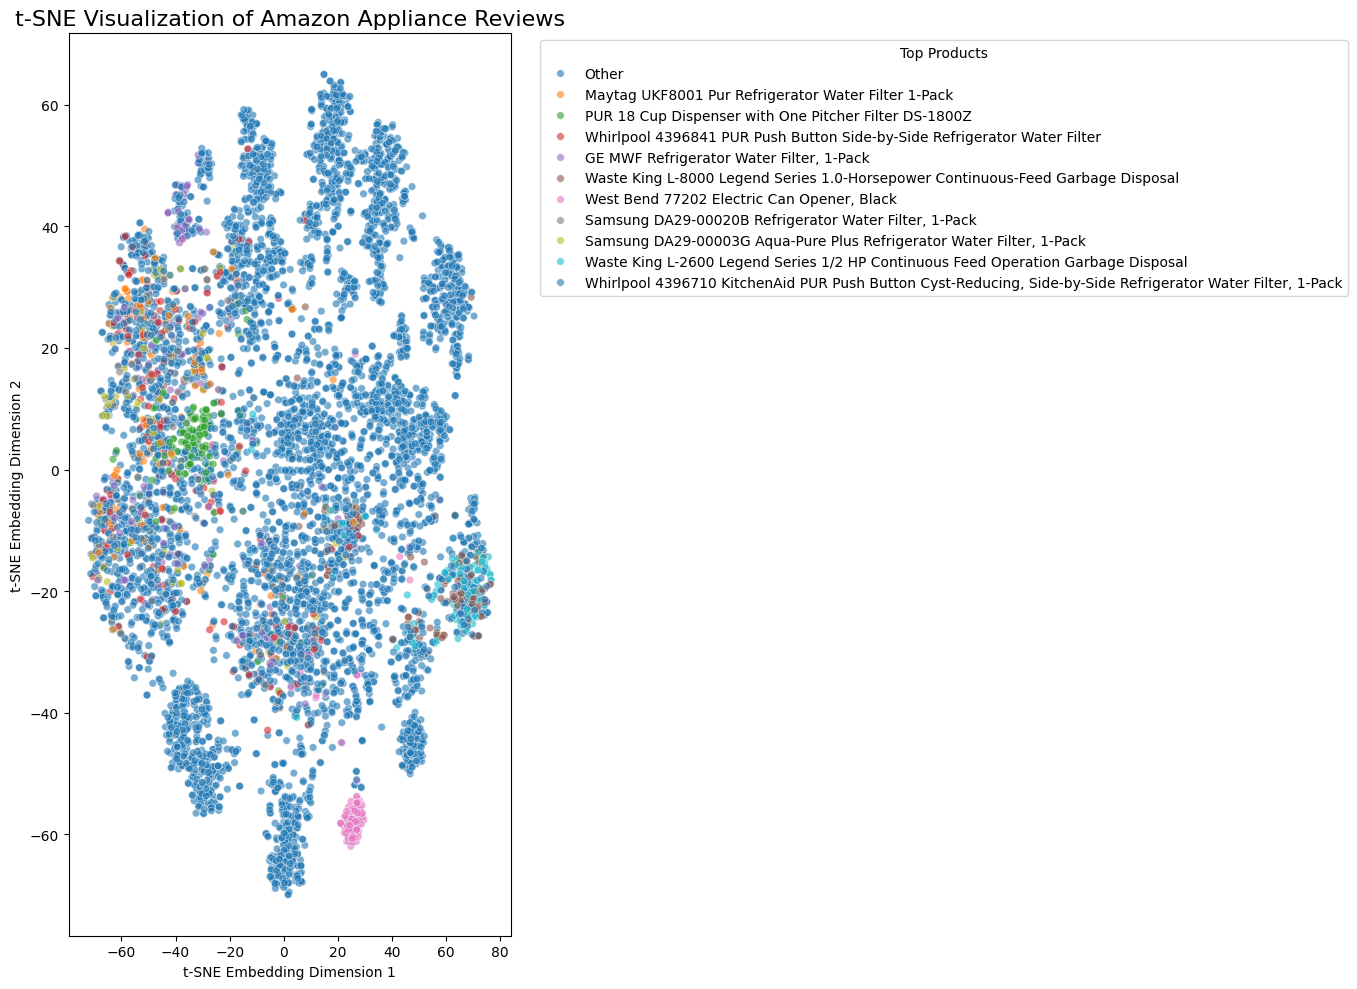

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# use reduced_embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(reduced_embeddings)

# add TSNE results to df
df['tsne-1'] = tsne_results[:, 0]
df['tsne-2'] = tsne_results[:, 1]

# Color by top N products
top_n = 10
top_products = df['title'].value_counts().nlargest(top_n).index
df['product_group'] = df['title'].where(df['title'].isin(top_products), 'Other')

# plot
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='tsne-1', y='tsne-2',
    hue='product_group',
    palette='tab10',
    data=df,
    alpha=0.6,
    s=30
)

plt.title("t-SNE Visualization of Amazon Appliance Reviews", fontsize=16)
plt.xlabel("t-SNE Embedding Dimension 1")
plt.ylabel("t-SNE Embedding Dimension 2")
plt.legend(title="Top Products", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# save plot
plt.savefig("tsne_visualization.png", dpi=300, bbox_inches='tight')

plt.show()



In [50]:
# download from colab
from google.colab import files
files.download("tsne_visualization.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>